In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
import pydot

from scipy import stats
from sklearn.preprocessing import PowerTransformer

import io
import matplotlib.image as mpimg

/home/zj448/miniconda3/envs/causal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
df=pd.read_csv('DMSOnly__clipped.csv')
df

,a,e,i,c,Class
0,41.304939,0.025709,12.733689,13.785976,b'Classical'
1,47.546931,0.292366,12.687931,18.797906,b'Resonant 2:1'
2,39.383632,0.138944,11.461713,14.189467,b'Resonant 3:2'
3,43.165308,0.073486,12.410094,34.737092,b'Classical'
4,39.377960,0.111109,22.351937,-0.869280,b'Resonant 3:2'
...,...,...,...,...,...
669,50.196671,0.265863,23.092965,8.204863,b'Detached'
670,45.872783,0.164537,33.278603,17.141963,b'Classical'
671,45.958993,0.210472,16.895071,18.420151,b'Classical'
672,88.298978,0.547606,30.626593,9.585839,b'Detached'


In [44]:
classes=np.unique(df['Class'])
classes

array(["b'Centaur'", "b'Classical insecure'", "b'Classical'",
       "b'Detached'", "b'Resonant 10:3'", "b'Resonant 11:2'",
       "b'Resonant 11:5'", "b'Resonant 11:6'", "b'Resonant 11:7'",
       "b'Resonant 12:7'", "b'Resonant 13:3'", "b'Resonant 13:6'",
       "b'Resonant 16:5'", "b'Resonant 1:1'", "b'Resonant 21:5'",
       "b'Resonant 23:11'", "b'Resonant 23:15'", "b'Resonant 25:3'",
       "b'Resonant 26:17'", "b'Resonant 29:16'", "b'Resonant 2:1'",
       "b'Resonant 3:1'", "b'Resonant 3:2'", "b'Resonant 4:1'",
       "b'Resonant 4:3'", "b'Resonant 5:2'", "b'Resonant 5:3'",
       "b'Resonant 5:4'", "b'Resonant 7:2'", "b'Resonant 7:3'",
       "b'Resonant 7:4'", "b'Resonant 7:5'", "b'Resonant 8:1'",
       "b'Resonant 9:4'", "b'Resonant candidate 10:1'",
       "b'Resonant candidate 11:6'", "b'Resonant candidate 13:7'",
       "b'Resonant candidate 19:12'", "b'Resonant candidate 19:6'",
       "b'Resonant candidate 21:10'", "b'Resonant candidate 22:13'",
       "b'Resonant cand

In [45]:
rename_dict = {'Centaur':'Centaurs','Classical':'Classicals','Detached':'Detached',
               'Resonant':'Resonant','Scattering':'Scattered'}

for i, row in df.iterrows():
    for j in rename_dict.keys():
        if j in row['Class']:
                df.at[i, 'Class'] = rename_dict[j]

In [46]:
classes=np.unique(df['Class'])
classes

array(['Centaurs', 'Classicals', 'Detached', 'Resonant', 'Scattered'],
      dtype=object)

In [47]:
df['obs'] = 'DES'

In [48]:
df2 = pd.read_csv('Col.csv')
df2

,a,e,i,c,Class
0,43.72,0.05,7.75,22.23,Classicals
1,43.86,0.10,31.67,20.64,Classicals
2,43.89,0.13,7.35,31.62,Classicals
3,42.18,0.05,8.03,31.50,Classicals
4,42.70,0.08,13.19,29.57,Classicals
...,...,...,...,...,...
224,61.79,0.39,5.79,9.88,Detached
225,55.30,0.29,22.46,16.60,Detached
226,46.16,0.49,44.89,14.30,Detached
227,150.15,0.73,33.54,18.50,Detached


In [49]:
df2['obs'] = 'Col-OSSOS'

In [50]:
df_full = pd.concat([df, df2], axis=0)
df_full

,a,e,i,c,Class,obs
0,41.304939,0.025709,12.733689,13.785976,Classicals,DES
1,47.546931,0.292366,12.687931,18.797906,Resonant,DES
2,39.383632,0.138944,11.461713,14.189467,Resonant,DES
3,43.165308,0.073486,12.410094,34.737092,Classicals,DES
4,39.377960,0.111109,22.351937,-0.869280,Resonant,DES
...,...,...,...,...,...,...
224,61.790000,0.390000,5.790000,9.880000,Detached,Col-OSSOS
225,55.300000,0.290000,22.460000,16.600000,Detached,Col-OSSOS
226,46.160000,0.490000,44.890000,14.300000,Detached,Col-OSSOS
227,150.150000,0.730000,33.540000,18.500000,Detached,Col-OSSOS


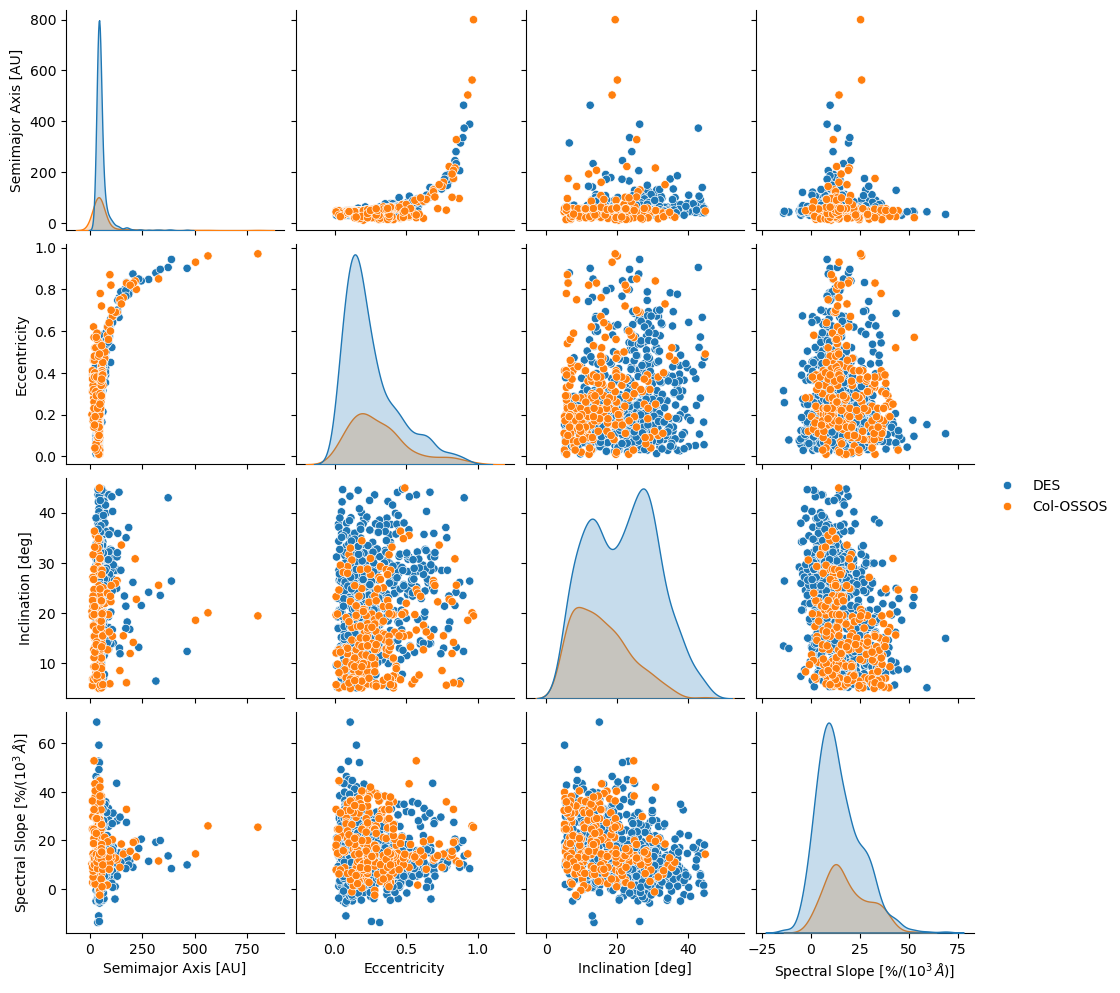

In [51]:
scatter_labels = ['Semimajor Axis [AU]', 'Eccentricity', 'Inclination [deg]', r'Spectral Slope $[\%/(10^3\,\AA)]$']
pairplot = sns.pairplot(df_full, hue='obs', vars=['a', 'e', 'i', 'c'], diag_kind='kde', palette="tab10")

# Remove the legend title
pairplot._legend.set_title(None)

# Change the y-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[i, 0].set_ylabel(label)

# Change the x-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[-1, i].set_xlabel(label)
plt.show()


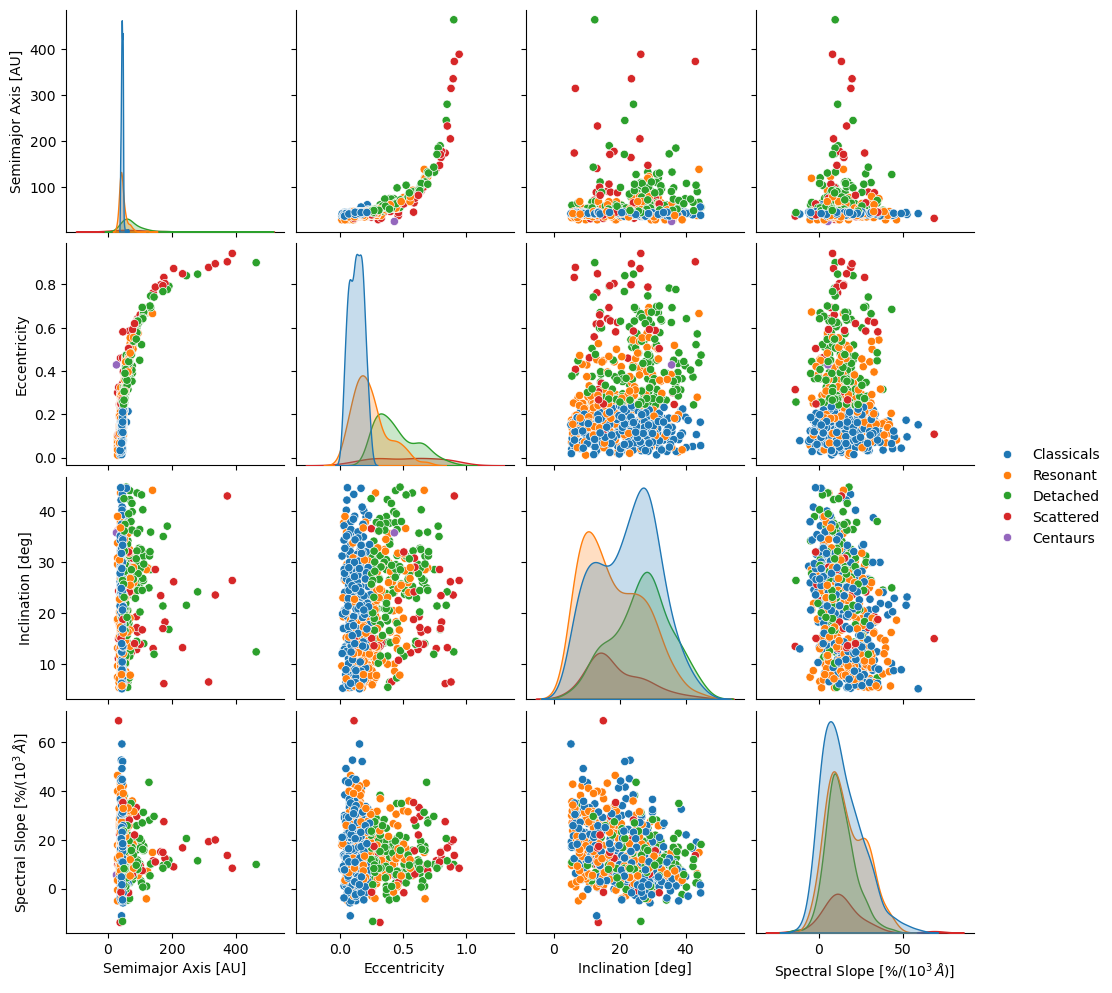

In [52]:
scatter_labels = ['Semimajor Axis [AU]', 'Eccentricity', 'Inclination [deg]', r'Spectral Slope $[\%/(10^3\,\AA)]$']

pairplot = sns.pairplot(df, hue="Class", diag_kind='kde', palette="tab10")

# Remove the legend title
pairplot._legend.set_title(None)

# Change the y-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[i, 0].set_ylabel(label)

# Change the x-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[-1, i].set_xlabel(label)
plt.show()

In [53]:
labels_list = [r'$\text{a}$',r'$\text{e}$', r'$\text{inc}$', r'$\text{color}$']

In [54]:
def causallearn_to_pydot(g,title=None,fontsize=25,dpi=500,latex_fontsize='xx-large',render_latex=True,labels_list=labels_list):

    # Render LaTeX to an image
    def render_latex_to_file(str, filepath):
        fig = plt.figure()
        fig = plt.figure(figsize=(0.01, 0.01))
        fig.text(0, 0, str, fontsize=latex_fontsize, ha='center', va='center')
        plt.axis('off')
        plt.savefig(filepath, bbox_inches='tight')
        plt.close(fig)

    if render_latex:
        for i,string in enumerate(labels_list):
            render_latex_to_file(string,'labels/label'+str(i)+'.png')

    #
    nodes = g.get_nodes()
    edges = g.get_graph_edges()

    pydot_g = pydot.Dot(graph_type="digraph")
    if dpi!=None:
        pydot_g.obj_dict["attributes"]["dpi"] = dpi

    for i, node in enumerate(nodes):
        node_name = node.get_name()
        pydot_g.add_node(pydot.Node(i, image='/home/zj448/causalTNOs/labels/label'+str(i)+'.png'
                                    ,label=""))

    def get_g_arrow_type(endpoint):
        if endpoint == Endpoint.TAIL:
            return 'none'
        elif endpoint == Endpoint.ARROW:
            return 'normal'
        elif endpoint == Endpoint.CIRCLE:
            return 'odot'
        else:
            raise NotImplementedError()
        
    for edge in edges:
        node1 = edge.get_node1()
        node2 = edge.get_node2()
        node1_id = nodes.index(node1)
        node2_id = nodes.index(node2)
        dot_edge = pydot.Edge(node1_id, node2_id, dir='both', arrowtail=get_g_arrow_type(edge.get_endpoint1()),
                                arrowhead=get_g_arrow_type(edge.get_endpoint2()))

        if Edge.Property.dd in edge.properties:
            dot_edge.obj_dict["attributes"]["color"] = "green3"

        if Edge.Property.nl in edge.properties:
            dot_edge.obj_dict["attributes"]["penwidth"] = 2.0

        pydot_g.add_edge(dot_edge)

    if title!=None:
        pydot_g.set_label(title)
        pydot_g.set_labelloc('t')
    pydot_g.set_fontsize(fontsize)
    pydot_g.set_fontname('Calibri')
    return pydot_g

# Fisher-z

Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 668.36it/s]


0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.006225

0 ind 3 | () with p-value 0.677015

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000004

1 ind 3 | () with p-value 0.180772

2 ind 0 | () with p-value 0.006225

2 dep 1 | () with p-value 0.000004

2 dep 3 | () with p-value 0.000000

3 ind 0 | () with p-value 0.677015

3 ind 1 | () with p-value 0.180772

3 dep 2 | () with p-value 0.000000

1 dep 0 | (2,) with p-value 0.000000

1 dep 2 | (0,) with p-value 0.000105

2 dep 1 | (3,) with p-value 0.000011

2 dep 3 | (1,) with p-value 0.000000

Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4
Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4


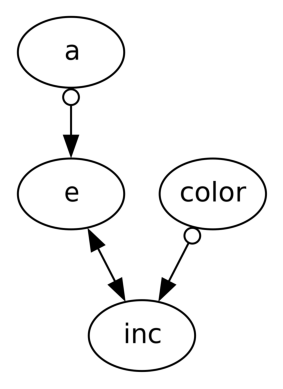

In [66]:
alpha=0.0002
g, edges = fci(np.array(df[['a','e','i','c']]),'fisherz',alpha=alpha,verbose=True,uc_rule=2)
pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

# KCI

Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 75.36it/s]


0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.568370

0 ind 3 | () with p-value 0.249814

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000511

1 ind 3 | () with p-value 0.009506

2 ind 0 | () with p-value 0.568370

2 dep 1 | () with p-value 0.000511

2 dep 3 | () with p-value 0.000000

3 ind 0 | () with p-value 0.249814

3 ind 1 | () with p-value 0.009506

3 dep 2 | () with p-value 0.000000

1 dep 0 | (2,) with p-value 0.001652

1 dep 2 | (0,) with p-value 0.000398

2 dep 1 | (3,) with p-value 0.002305

2 dep 3 | (1,) with p-value 0.000000

Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4
Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4


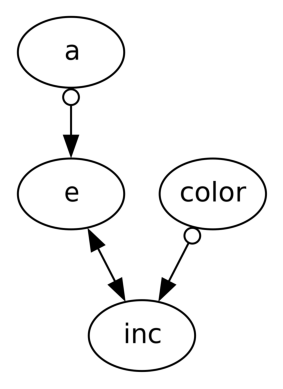

In [65]:
alpha=0.0024
g, edges = fci(np.array(df[['a','e','i','c']]),'kci',polyd=2, kernelX='Polynomial', kernelY='Polynomial', kernelZ='Polynomial',alpha=alpha,verbose=True,uc_rule=2)
# g, edges = fci(np.array(df[['a','e','i','c']]),'kci',alpha=alpha,verbose=True,uc_rule=2)
pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

# Leave one out for each population

Without Centaurs sample_size: 673 alpha: 0.001


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 733.43it/s]


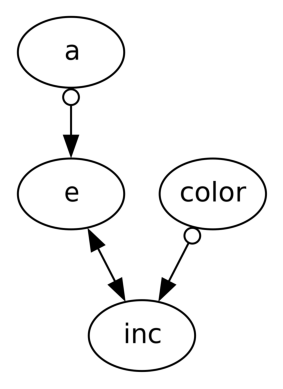

Without Classicals sample_size: 399 alpha: 0.001


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 771.90it/s]


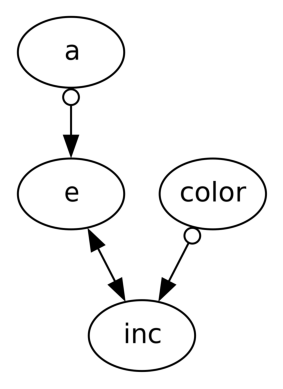

Without Detached sample_size: 529 alpha: 0.001


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 679.68it/s]


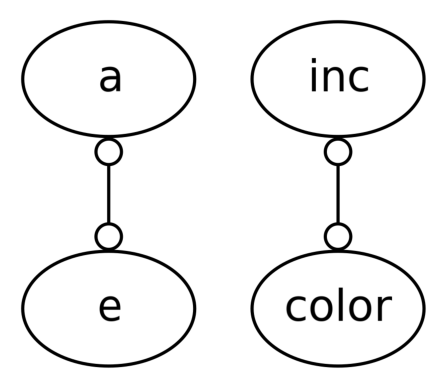

Without Resonant sample_size: 467 alpha: 0.01


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 841.68it/s]


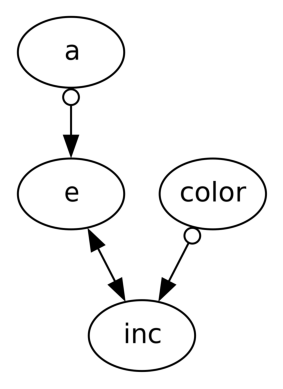

Without Scattered sample_size: 628 alpha: 0.001


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 696.87it/s]


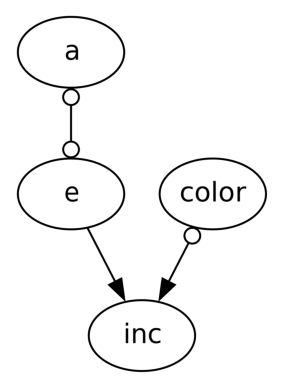

In [68]:
alpha=[1e-3,1e-3,1e-3,1e-2,1e-3]
for i, class2 in enumerate(classes):
    print('Without',class2,'sample_size:',len(df[df['Class']!=class2]),'alpha:',alpha[i])
    df_no_res = df[df['Class']!=class2][['a','e','i','c']]
    g, edges = fci(np.array(df_no_res),'fisherz',alpha=alpha[i],verbose=False,uc_rule=2)
    # if class2=='Detached':
    #     # g, edges = fci(np.array(df_no_res),'kci',polyd=2, kernelX='Polynomial', kernelY='Polynomial', kernelZ='Polynomial',alpha=alpha[i],verbose=True,uc_rule=2)
    #     g, edges = fci(np.array(df_no_res),'kci',alpha=alpha[i],verbose=True,uc_rule=2)
    # else:
    #     g, edges = fci(np.array(df_no_res),'fisherz',alpha=alpha[i],verbose=False,uc_rule=2)
    pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

# Each Sub-populations

Class: Centaurs sample_size: 1 alpha: 0.3
Skipping class Centaurs due to insufficient data.
Class: Classicals sample_size: 275 alpha: 0.09


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 745.06it/s]

0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.910735

0 ind 3 | () with p-value 0.664240

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.037585

1 ind 3 | () with p-value 0.179880

2 ind 0 | () with p-value 0.910735

2 dep 1 | () with p-value 0.037585

2 dep 3 | () with p-value 0.000000

3 ind 0 | () with p-value 0.664240

3 ind 1 | () with p-value 0.179880

3 dep 2 | () with p-value 0.000000

1 dep 0 | (2,) with p-value 0.000000

1 dep 2 | (0,) with p-value 0.009079

2 dep 1 | (3,) with p-value 0.088338

2 dep 3 | (1,) with p-value 0.000000

Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4
Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4


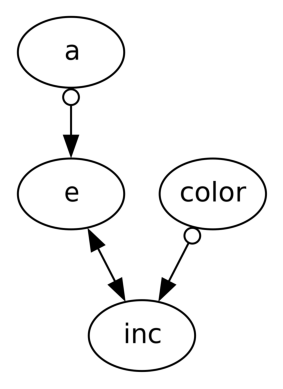

Class: Detached sample_size: 145 alpha: 0.4


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 691.64it/s]

0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.534766

0 ind 3 | () with p-value 0.704513

1 dep 0 | () with p-value 0.000000

1 ind 2 | () with p-value 0.678636

1 ind 3 | () with p-value 0.506560

2 ind 0 | () with p-value 0.534766

2 ind 1 | () with p-value 0.678636

2 dep 3 | () with p-value 0.083927

3 ind 0 | () with p-value 0.704513

3 ind 1 | () with p-value 0.506560

3 dep 2 | () with p-value 0.083927



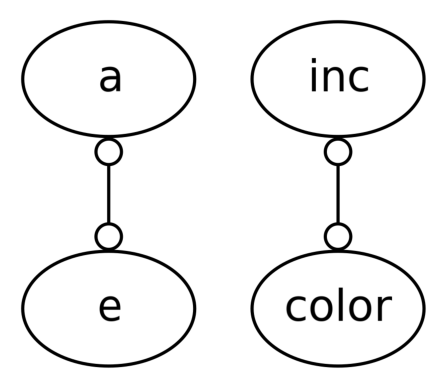

Class: Resonant sample_size: 207 alpha: 0.05


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 701.39it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000001

0 ind 3 | () with p-value 0.416482

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000002

1 ind 3 | () with p-value 0.121392

2 dep 0 | () with p-value 0.000001

2 dep 1 | () with p-value 0.000002

2 dep 3 | () with p-value 0.000007

3 ind 0 | () with p-value 0.416482

3 ind 1 | () with p-value 0.121392

3 dep 2 | () with p-value 0.000007

0 dep 1 | (2,) with p-value 0.000000

0 ind 2 | (1,) with p-value 0.112342

1 dep 0 | (2,) with p-value 0.000000

1 ind 2 | (0,) with p-value 0.178288

2 ind 0 | (1,) with p-value 0.112342

2 dep 0 | (3,) with p-value 0.000001

2 ind 1 | (0,) with p-value 0.178288

2 dep 1 | (3,) with p-value 0.000006

2 dep 3 | (0,) with p-value 0.000009

2 dep 3 | (1,) with p-value 0.000028



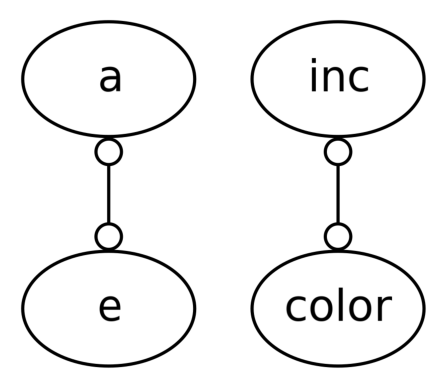

Class: Scattered sample_size: 46 alpha: 0.2


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 791.83it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.183712

0 ind 3 | () with p-value 0.791644

1 dep 0 | () with p-value 0.000000

1 ind 2 | () with p-value 0.244890

1 ind 3 | () with p-value 0.939787

2 dep 0 | () with p-value 0.183712

2 ind 1 | () with p-value 0.244890

2 ind 3 | () with p-value 0.294671

3 ind 0 | () with p-value 0.791644

3 ind 1 | () with p-value 0.939787

3 ind 2 | () with p-value 0.294671

0 dep 1 | (2,) with p-value 0.000000

0 ind 2 | (1,) with p-value 0.516943



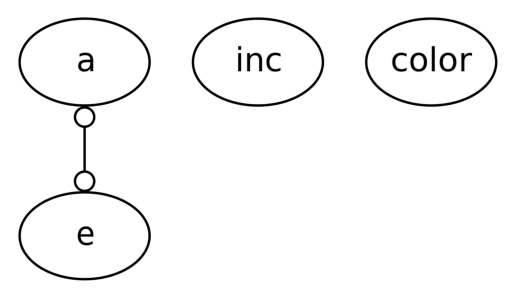

In [69]:
alpha=[0.3,0.09,0.4,0.05,0.2]
for i,class2 in enumerate(classes):
    print('Class:',class2,'sample_size:',len(df[df['Class']==class2]),'alpha:',alpha[i])
    df_class = df[df['Class']==class2][['a','e','i','c']]
    if len(df_class) < 10:
        print(f"Skipping class {class2} due to insufficient data.")
        continue
    g, edges = fci(np.array(df_class),'fisherz',alpha=alpha[i],verbose=True,uc_rule=2)
    pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()